In [40]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
if not os.getcwd().endswith('cfdna_snv_benchmark'):
    os.chdir('../')
print('Current working directory: {}'.format(os.getcwd()))

cosmic_pd = pd.read_csv(os.path.join('data', 'extdata', 'CosmicMutantExport.tsv'), encoding='ISO-8859-1', sep='\t', memory_map=True)
print(cosmic_pd.columns)
print(cosmic_pd.shape)

Current working directory: /Users/hanae/Repositories/cfdna_snv_benchmark
Index(['Gene name', 'Accession Number', 'Gene CDS length', 'HGNC ID',
       'Sample name', 'ID_sample', 'ID_tumour', 'Primary site',
       'Site subtype 1', 'Site subtype 2', 'Site subtype 3',
       'Primary histology', 'Histology subtype 1', 'Histology subtype 2',
       'Histology subtype 3', 'Genome-wide screen', 'GENOMIC_MUTATION_ID',
       'LEGACY_MUTATION_ID', 'MUTATION_ID', 'Mutation CDS', 'Mutation AA',
       'Mutation Description', 'Mutation zygosity', 'LOH', 'GRCh',
       'Mutation genome position', 'Mutation strand', 'Resistance Mutation',
       'FATHMM prediction', 'FATHMM score', 'Mutation somatic status',
       'Pubmed_PMID', 'ID_STUDY', 'Sample Type', 'Tumour origin', 'Age',
       'HGVSP', 'HGVSC', 'HGVSG'],
      dtype='object')
(49244410, 39)
               Gene name   Accession Number  Gene CDS length  HGNC ID  \
0  NCOR2_ENST00000404621  ENST00000404621.5             7377   7673.0   
1 

## COLUMNS
['Gene name', 'Accession Number', 'Gene CDS length', 'HGNC ID',
'Sample name', 'ID_sample', 'ID_tumour', 'Primary site',
'Site subtype 1', 'Site subtype 2', 'Site subtype 3',
'Primary histology', 'Histology subtype 1', 'Histology subtype 2',
'Histology subtype 3', 'Genome-wide screen', 'GENOMIC_MUTATION_ID',
'LEGACY_MUTATION_ID', 'MUTATION_ID', 'Mutation CDS', 'Mutation AA',
'Mutation Description', 'Mutation zygosity', 'LOH', 'GRCh',
'Mutation genome position', 'Mutation strand', 'Resistance Mutation',
'FATHMM prediction', 'FATHMM score', 'Mutation somatic status',
'Pubmed_PMID', 'ID_STUDY', 'Sample Type', 'Tumour origin', 'Age',
'HGVSP', 'HGVSC', 'HGVSG']

## PRIMARY SITES
['breast' 'haematopoietic_and_lymphoid_tissue' 'lung' 'liver'
 'endometrium' 'upper_aerodigestive_tract' 'large_intestine' 'skin'
 'kidney' 'soft_tissue' 'ovary' 'central_nervous_system' 'biliary_tract'
 'stomach' 'oesophagus' 'prostate' 'urinary_tract' 'bone'
 'autonomic_ganglia' 'penis' 'uterine_adnexa' 'cervix' 'pancreas' 'NS'
 'testis' 'thyroid' 'pleura' 'placenta' 'meninges' 'small_intestine'
 'genital_tract' 'adrenal_gland' 'salivary_gland' 'thymus' 'peritoneum'
 'eye' 'parathyroid' 'pituitary'
 'gastrointestinal_tract_(site_indeterminate)'
 'female_genital_tract_(site_indeterminate)' 'vulva' 'fallopian_tube'
 'vagina' 'paratesticular_tissues' 'perineum' 'retroperitoneum'
 'pericardium' 'mediastinum' 'female_genitourinary_system']

In [186]:
cosmic_muts = cosmic_pd[(cosmic_pd['Primary site'] == 'large_intestine') & (cosmic_pd['Site subtype 1'] == 'colon') & (cosmic_pd['Tumour origin'] == 'primary')]
print(cosmic_muts.shape)
cosmic_muts.head()

(284193, 39)


,Gene name,Accession Number,Gene CDS length,HGNC ID,Sample name,ID_sample,ID_tumour,Primary site,Site subtype 1,Site subtype 2,...,FATHMM score,Mutation somatic status,Pubmed_PMID,ID_STUDY,Sample Type,Tumour origin,Age,HGVSP,HGVSC,HGVSG
34,SELP_ENST00000458599,ENST00000458599.6,1941,10721.0,587226,1766750,1671070,large_intestine,colon,NS,...,0.96755,Variant of unknown origin,22895193.0,NaN,surgery fresh/frozen,primary,NaN,ENSP00000399368.2:p.Arg472Met,ENST00000458599.6:c.1415G>T,1:g.169596059C>A
64,SELP_ENST00000458599,ENST00000458599.6,1941,10721.0,587376,1766805,1671125,large_intestine,colon,NS,...,0.80149,Variant of unknown origin,22895193.0,NaN,surgery fresh/frozen,primary,NaN,ENSP00000399368.2:p.Cys386Ter,ENST00000458599.6:c.1158C>A,1:g.169607124G>T
321,SELP_ENST00000458599,ENST00000458599.6,1941,10721.0,587228,1766751,1671071,large_intestine,colon,NS,...,0.07426,Variant of unknown origin,22895193.0,NaN,surgery fresh/frozen,primary,NaN,ENSP00000399368.2:p.Arg396Trp,ENST00000458599.6:c.1186C>T,1:g.169607096G>A
327,SELP_ENST00000458599,ENST00000458599.6,1941,10721.0,587222,1766748,1671068,large_intestine,colon,NS,...,0.08181,Reported in another cancer sample as somatic,22895193.0,NaN,surgery fresh/frozen,primary,NaN,ENSP00000399368.2:p.Arg367Trp,ENST00000458599.6:c.1099C>T,1:g.169609552G>A
337,SELP_ENST00000458599,ENST00000458599.6,1941,10721.0,587376,1766805,1671125,large_intestine,colon,NS,...,0.07496,Reported in another cancer sample as somatic,22895193.0,NaN,surgery fresh/frozen,primary,NaN,NaN,ENST00000458599.6:c.1339+3878C>T,1:g.169603065G>A


1.0 3.7619249973440985 2.0 4.0


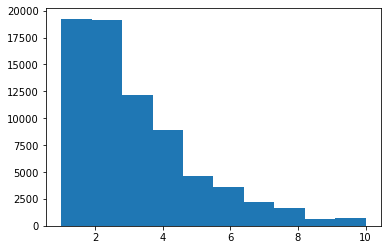

In [187]:
# describe occurences
occurences = cosmic_muts['Mutation genome position'].value_counts().values
plt.hist(occurences[occurences <= 10])
print(np.quantile(occurences, 0.25), np.mean(occurences), np.median(occurences), np.quantile(occurences, 0.75))
# set threshold = at least 3 patients
threshold = 5

In [188]:
occ = cosmic_muts['Mutation genome position'].value_counts() 
common_muts_occ = occ[occ >= threshold]
common_muts = common_muts_occ.index
print(len(common_muts))

15867


In [189]:
cosmic_muts['chrom'] = cosmic_muts['Mutation genome position'].str.split(':').str[0]
cosmic_muts['startpos'] = cosmic_muts['Mutation genome position'].str.split(':').str[1].str.split('-').str[0]
cosmic_muts['endpos'] = cosmic_muts['Mutation genome position'].str.split(':').str[1].str.split('-').str[1]
cosmic_muts['chrom_pos'] = cosmic_muts['chrom'] + '_' + cosmic_muts['startpos'] + '_' + cosmic_muts['endpos']
cosmic_muts.dropna(subset=['chrom', 'startpos', 'endpos'], inplace=True)
cosmic_muts['chrom'] = cosmic_muts['chrom'].astype(int)
cosmic_muts['startpos'] = cosmic_muts['startpos'].astype(int)
cosmic_muts['endpos'] = cosmic_muts['endpos'].astype(int)
cosmic_muts.sort_values(by=['chrom', 'startpos', 'endpos'], axis=0, inplace=True)

/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [193]:
cosmic_muts[cosmic_muts['type'] == 'INS']['HGVSG']

334962        1:g.1046488dup
10861747      1:g.1046488dup
333634        1:g.1051751dup
10861280      1:g.1051751dup
13804472      1:g.2025341dup
                  ...       
34007347    X:g.151924260dup
4771796     X:g.153803866dup
11168055    X:g.153803866dup
13997479    X:g.153803866dup
31715175    X:g.154904931dup
Name: HGVSG, Length: 3948, dtype: object

In [191]:
print(cosmic_muts['Mutation Description'].unique()) # SNV or INDEL
cosmic_muts['type'] = np.nan
cosmic_muts['type'][cosmic_muts['Mutation Description'].str.contains('Substitution') == True] = 'SNV'
cosmic_muts['type'][cosmic_muts['Mutation Description'].str.contains('Insertion') == True] = 'INS'
cosmic_muts['type'][cosmic_muts['Mutation Description'].str.contains('Deletion') == True] = 'DEL'
cosmic_muts.dropna(subset=['type'], inplace=True)
cosmic_muts

['Substitution - Missense' 'Unknown' 'Substitution - Nonsense'
 'Substitution - coding silent' 'Insertion - Frameshift' nan
 'Deletion - Frameshift' 'Deletion - In frame' 'Nonstop extension'
 'Insertion - In frame' 'Complex - frameshift' 'Frameshift']


/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in th

,Gene name,Accession Number,Gene CDS length,HGNC ID,Sample name,ID_sample,ID_tumour,Primary site,Site subtype 1,Site subtype 2,...,Tumour origin,Age,HGVSP,HGVSC,HGVSG,chrom,startpos,endpos,chrom_pos,type
34214343,NOC2L,ENST00000327044.6,2250,24517.0,4989_PT,2501004,2363355,large_intestine,colon,right,...,primary,68.0,ENSP00000317992.6:p.Arg519Gln,ENST00000327044.6:c.1556G>A,1:g.948491C>T,1,948491,948491,1_948491_948491,SNV
29334804,NOC2L,ENST00000327044.6,2250,24517.0,587238,1863429,1754320,large_intestine,colon,NS,...,primary,NaN,ENSP00000317992.6:p.Ala517Val,ENST00000327044.6:c.1550C>T,1:g.948497G>A,1,948497,948497,1_948497_948497,SNV
28611323,NOC2L,ENST00000327044.6,2250,24517.0,587376,1766805,1671125,large_intestine,colon,NS,...,primary,NaN,ENSP00000317992.6:p.Arg297Ile,ENST00000327044.6:c.890G>T,1:g.953287C>A,1,953287,953287,1_953287_953287,SNV
33588431,NOC2L,ENST00000327044.6,2250,24517.0,2476_PT,2500986,2363337,large_intestine,colon,left,...,primary,57.0,ENSP00000317992.6:p.Arg185Gln,ENST00000327044.6:c.554G>A,1:g.956148C>T,1,956148,956148,1_956148_956148,SNV
31124096,NOC2L,ENST00000327044.6,2250,24517.0,TCGA-G5-6233-01,1651644,1566431,large_intestine,colon,sigmoid,...,primary,74.0,ENSP00000317992.6:p.Glu33Asp,ENST00000327044.6:c.99A>C,1:g.959009T>G,1,959009,959009,1_959009_959009,SNV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34139957,KDM5D_ENST00000541639,ENST00000541639.5,4713,11115.0,587332,1766784,1671104,large_intestine,colon,NS,...,primary,NaN,ENSP00000444293.1:p.Leu1424Phe,ENST00000541639.5:c.4270C>T,Y:g.19706533G>A,24,19706533,19706533,24_19706533_19706533,SNV
6038248,KDM5D,ENST00000317961.8,4620,11115.0,587228,1766751,1671071,large_intestine,colon,NS,...,primary,NaN,ENSP00000322408.4:p.Arg159His,ENST00000317961.8:c.476G>A,Y:g.19741364C>T,24,19741364,19741364,24_19741364_19741364,SNV
35118985,KDM5D_ENST00000541639,ENST00000541639.5,4713,11115.0,587228,1766751,1671071,large_intestine,colon,NS,...,primary,NaN,ENSP00000444293.1:p.Arg159His,ENST00000541639.5:c.476G>A,Y:g.19741364C>T,24,19741364,19741364,24_19741364_19741364,SNV
16673350,EIF1AY_ENST00000382772,ENST00000382772.3,384,3252.0,587332,1766784,1671104,large_intestine,colon,NS,...,primary,NaN,ENSP00000372222.3:p.Arg13Leu,ENST00000382772.3:c.38G>T,Y:g.20579629G>T,24,20579629,20579629,24_20579629_20579629,SNV


In [199]:
# info about nomenclature http://varnomen.hgvs.org/recommendations/DNA/
cosmic_muts['ref'] = np.nan
cosmic_muts['alt'] = np.nan
cosmic_muts['ref'][cosmic_muts['type'] == 'SNV'] = cosmic_muts[cosmic_muts['type'] == 'SNV']['Mutation CDS'].str.split('>').str[0].str[-1] 
cosmic_muts['alt'][cosmic_muts['type'] == 'SNV'] = cosmic_muts[cosmic_muts['type'] == 'SNV']['Mutation CDS'].str.split('>').str[1]
cosmic_muts['alt'][cosmic_muts['type'] == 'INS'] = cosmic_muts[cosmic_muts['type'] == 'INS']['Mutation CDS'].str.split('ins').str[1] 
cosmic_muts

/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/hanae/opt/anaconda3/envs/default/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a co

,Gene name,Accession Number,Gene CDS length,HGNC ID,Sample name,ID_sample,ID_tumour,Primary site,Site subtype 1,Site subtype 2,...,HGVSP,HGVSC,HGVSG,chrom,startpos,endpos,chrom_pos,type,ref,alt
34214343,NOC2L,ENST00000327044.6,2250,24517.0,4989_PT,2501004,2363355,large_intestine,colon,right,...,ENSP00000317992.6:p.Arg519Gln,ENST00000327044.6:c.1556G>A,1:g.948491C>T,1,948491,948491,1_948491_948491,SNV,G,A
29334804,NOC2L,ENST00000327044.6,2250,24517.0,587238,1863429,1754320,large_intestine,colon,NS,...,ENSP00000317992.6:p.Ala517Val,ENST00000327044.6:c.1550C>T,1:g.948497G>A,1,948497,948497,1_948497_948497,SNV,C,T
28611323,NOC2L,ENST00000327044.6,2250,24517.0,587376,1766805,1671125,large_intestine,colon,NS,...,ENSP00000317992.6:p.Arg297Ile,ENST00000327044.6:c.890G>T,1:g.953287C>A,1,953287,953287,1_953287_953287,SNV,G,T
33588431,NOC2L,ENST00000327044.6,2250,24517.0,2476_PT,2500986,2363337,large_intestine,colon,left,...,ENSP00000317992.6:p.Arg185Gln,ENST00000327044.6:c.554G>A,1:g.956148C>T,1,956148,956148,1_956148_956148,SNV,G,A
31124096,NOC2L,ENST00000327044.6,2250,24517.0,TCGA-G5-6233-01,1651644,1566431,large_intestine,colon,sigmoid,...,ENSP00000317992.6:p.Glu33Asp,ENST00000327044.6:c.99A>C,1:g.959009T>G,1,959009,959009,1_959009_959009,SNV,A,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34139957,KDM5D_ENST00000541639,ENST00000541639.5,4713,11115.0,587332,1766784,1671104,large_intestine,colon,NS,...,ENSP00000444293.1:p.Leu1424Phe,ENST00000541639.5:c.4270C>T,Y:g.19706533G>A,24,19706533,19706533,24_19706533_19706533,SNV,C,T
6038248,KDM5D,ENST00000317961.8,4620,11115.0,587228,1766751,1671071,large_intestine,colon,NS,...,ENSP00000322408.4:p.Arg159His,ENST00000317961.8:c.476G>A,Y:g.19741364C>T,24,19741364,19741364,24_19741364_19741364,SNV,G,A
35118985,KDM5D_ENST00000541639,ENST00000541639.5,4713,11115.0,587228,1766751,1671071,large_intestine,colon,NS,...,ENSP00000444293.1:p.Arg159His,ENST00000541639.5:c.476G>A,Y:g.19741364C>T,24,19741364,19741364,24_19741364_19741364,SNV,G,A
16673350,EIF1AY_ENST00000382772,ENST00000382772.3,384,3252.0,587332,1766784,1671104,large_intestine,colon,NS,...,ENSP00000372222.3:p.Arg13Leu,ENST00000382772.3:c.38G>T,Y:g.20579629G>T,24,20579629,20579629,24_20579629_20579629,SNV,G,T


In [209]:
cosmic_bed = cosmic_muts[['chrom_pos', 'chrom', 'startpos', 'endpos', 'alt', 'type']].set_index('chrom_pos')
cosmic_bed.drop_duplicates(inplace=True)
print(cosmic_bed.shape)
print(cosmic_bed[cosmic_bed['type'] == 'INS'].head())
print(cosmic_bed[cosmic_bed['type'] == 'DEL'].head())
cosmic_bed.head()

(71140, 5)
                   chrom  startpos   endpos  alt type
chrom_pos                                            
1_1046488_1046489      1   1046488  1046489  NaN  INS
1_1051751_1051752      1   1051751  1051752  NaN  INS
1_2025341_2025342      1   2025341  2025342  NaN  INS
1_4712554_4712555      1   4712554  4712555  NaN  INS
1_6667755_6667756      1   6667755  6667756  NaN  INS
                   chrom  startpos   endpos  alt type
chrom_pos                                            
1_1964999_1964999      1   1964999  1964999  NaN  DEL
1_2504508_2504508      1   2504508  2504508  NaN  DEL
1_2511668_2511668      1   2511668  2511668  NaN  DEL
1_2561790_2561791      1   2561790  2561791  NaN  DEL
1_3771467_3771467      1   3771467  3771467  NaN  DEL


,chrom,startpos,endpos,alt,type
chrom_pos,,,,,
1_948491_948491,1,948491,948491,A,SNV
1_948497_948497,1,948497,948497,T,SNV
1_953287_953287,1,953287,953287,T,SNV
1_956148_956148,1,956148,956148,A,SNV
1_959009_959009,1,959009,959009,C,SNV


# How many SNVs and INDELs per chromosomes to be inserted as ground truth?

1     6494
2     5757
3     4252
4     2672
5     3399
6     3100
7     3200
8     2477
9     2646
10    2580
11    3849
12    3533
13    1416
14    1815
15    1967
16    2824
17    3644
18    1142
19    5021
20    1750
21     704
22    1296
23    2147
24      12
Name: chrom, dtype: int64
1     285
2     233
3     209
4     127
5     382
6     145
7     138
8      89
9     114
10    147
11    184
12    178
13     85
14     70
15     90
16    133
17    310
18     52
19    207
20     63
21     28
22     62
23    112
Name: chrom, dtype: int64


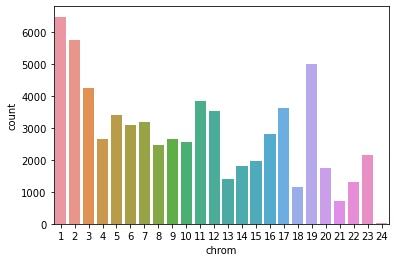

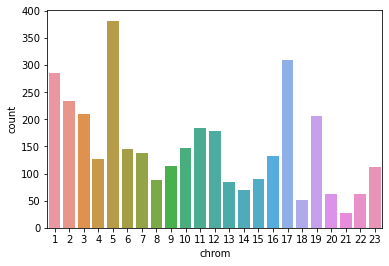

In [211]:
sns.countplot(x='chrom', data=cosmic_bed[cosmic_bed['type'] == 'SNV'])
print(cosmic_bed[cosmic_bed['type'] == 'SNV']['chrom'].value_counts().sort_index())
plt.figure()
sns.countplot(x='chrom', data=cosmic_bed[(cosmic_bed['type'] == 'INS') | (cosmic_bed['type'] == 'DEL')])
print(cosmic_bed[(cosmic_bed['type'] == 'INS') | (cosmic_bed['type'] == 'DEL')]['chrom'].value_counts().sort_index())

# Save for bamsurgeon

In [203]:
# /!\ 0-based index in bamsurgeon for indels
# but VCF del: ATC -> A, input BED del: - 2 nucleotides
# but VCF ins: A -> ATC, input BED ins: + TC